In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind , pearsonr , chi2 , kstest, ks_1samp
from scipy.stats import norm,lognorm ,genlogistic ,genexpon,gennorm,genpareto,pareto , weibull_min,t
from scipy.stats import probplot
from sklearn.linear_model import LinearRegression 
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

import folium

#pour les tableaux
import plotly.graph_objects as go

In [2]:
#Paramètres généraux pour les graphiques
couleur_axes="dimgray"
couleur_texte="darkslategray"

df_sect_couleurs=pd.DataFrame({"Secteur":["Résidentiel","Tertiaire","Industriel","Agricole","Non affecté"],
                               "Couleur":["orange","yellowgreen","gold","lime","cyan"]})


In [3]:
#Chargement des données énergie
conso_an_secteur=pd.read_csv(r"C:\DATA\énergie\conso_an_secteur.csv")

#Pas de vérification : les problèmes ont été traités dans le notebook de préparation

#Les consommations sont exprimées en MWh dans le fichier initial

In [4]:
conso_an_secteur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377076 entries, 0 to 377075
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   conso_agri_elec    377076 non-null  float64
 1   conso_ter_elec     377076 non-null  float64
 2   conso_indus_elec   377076 non-null  float64
 3   conso_resid_elec   377076 non-null  float64
 4   conso_nonaff_elec  377076 non-null  float64
 5   conso_totale_elec  377076 non-null  float64
 6   conso_agri_gaz     377076 non-null  float64
 7   conso_ter_gaz      377076 non-null  float64
 8   conso_indus_gaz    377076 non-null  float64
 9   conso_resid_gaz    377076 non-null  float64
 10  conso_nonaff_gaz   377076 non-null  float64
 11  conso_totale_gaz   377076 non-null  float64
 12  conso_agri         377076 non-null  float64
 13  conso_ter          377076 non-null  float64
 14  conso_indus        377076 non-null  float64
 15  conso_resid        377076 non-null  float64
 16  co

In [5]:
#Analyse à l'échelle EPCI pour l'année 2021

In [6]:
#Prévoir un descriptif sur EPCI

In [7]:
#1ère approche 2021
conso_communes_2021=conso_an_secteur[conso_an_secteur["année"]==2021]

In [8]:
#Regroupement à l'échelle ecpi
conso_epci_2021=conso_communes_2021.groupby(['code_epci', 'nom_epci','nature_epci','nb_com'],as_index=False).agg({
        'conso_agri_elec':"sum", 'conso_ter_elec':"sum", 'conso_indus_elec':"sum", 'conso_resid_elec':"sum",
        'conso_nonaff_elec':"sum",'conso_totale_elec':"sum", 'conso_agri_gaz':"sum", 'conso_ter_gaz':"sum",
        'conso_indus_gaz':"sum", 'conso_resid_gaz':"sum", 'conso_nonaff_gaz':"sum",'conso_totale_gaz':"sum",
        'conso_agri':"sum", 'conso_ter':"sum", 'conso_indus':"sum",
       'conso_resid':"sum", 'conso_nonaff':"sum", 'conso_totale':"sum",'superficie':"sum", 'population':"sum"
})

#Attention: on supprime les départements et régions parce que les ECPI peuvent être à cheval 

In [9]:
#Ajout d'une variable densité de population
conso_epci_2021["dens_pop"]=conso_epci_2021["population"]/conso_epci_2021["superficie"]

In [10]:
#Ajouts de variables d'autres sources 

#Ajout des établissements --> source base Sirène  au 1er juillet 2023
infos_etabl=pd.read_csv(r"C:\DATA\énergie\nb_etabl_secteur_epci.csv")
conso_epci_2021=conso_epci_2021.merge(right=infos_etabl,on="code_epci",how="left")


In [11]:
#Valeurs manquantes
conso_epci_2021.isna().sum()

#RAS

code_epci               0
nom_epci                0
nature_epci             0
nb_com                  0
conso_agri_elec         0
conso_ter_elec          0
conso_indus_elec        0
conso_resid_elec        0
conso_nonaff_elec       0
conso_totale_elec       0
conso_agri_gaz          0
conso_ter_gaz           0
conso_indus_gaz         0
conso_resid_gaz         0
conso_nonaff_gaz        0
conso_totale_gaz        0
conso_agri              0
conso_ter               0
conso_indus             0
conso_resid             0
conso_nonaff            0
conso_totale            0
superficie              0
population              0
dens_pop                0
nb_etabl_Agriculture    0
nb_siège_Agriculture    0
nb_etabl_Industrie      0
nb_siège_Industrie      0
nb_etabl_Tertiaire      0
nb_siège_Tertiaire      0
dtype: int64

In [12]:
#Nombre d' epci
print("A l'origine ,le nombre de EPCI est: ",len(conso_epci_2021["code_epci"].unique()))

#Suppression des  lignes avec libellé_ecpi='sans intercommunalité'
conso_epci_2021=conso_epci_2021[conso_epci_2021["nom_epci"]!='sans intercommunalité']

nb_epci=len(conso_epci_2021["code_epci"].unique())
print("Le nombre final de EPCI est: ",nb_epci)

A l'origine ,le nombre de EPCI est:  1232
Le nombre final de EPCI est:  1231


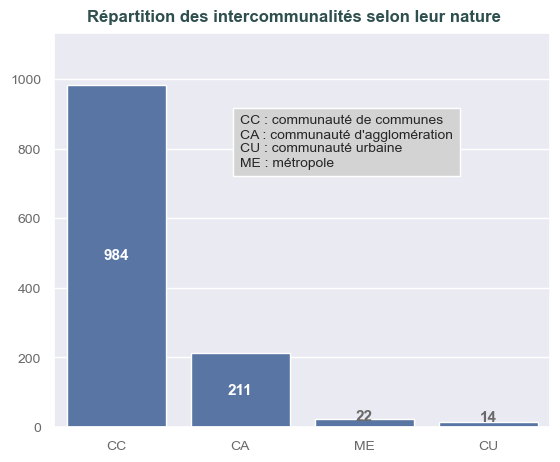

In [13]:
#Informations sur les EPCI 
#On ne rentre pas dans le détail des données EPCI ici-ce sera fait plus loin
#Il s'agit simplement d'indiquer qu'il y a différentes natures d' EPCI

"""
La métropole de Lyon, créée par la loi MAPTAM, est une collectivité territoriale et non une intercommunalité.
Elle n'est donc pas une métropole au sens de la loi de 2010. 
Elle est intégrée dans ce fichier aux EPCI avec une nature spécifique (METLYON).


Les métropoles d'Aix-Marseille-Provence et du Grand Paris sont deux métropoles à statut particulier.

"""

conso_epci_2021=conso_epci_2021.replace(to_replace="METLYON",value="ME")

#Graphique de la distribution de epci selon leur nature
fig,ax=plt.subplots()
sns.countplot(conso_epci_2021,x="nature_epci",ax=ax , color="#4c72b0")
plt.xticks(color=couleur_axes,size=10)
plt.yticks(color=couleur_axes,size=10)
ech=0
i=0
for p in ax.patches: 
        i+=1
        val=p.get_height()
        if val>ech:
            ech=val
        if i<=2:    
            ax.text(p.get_x()+ p.get_width()/2.,val/2,
                '{}'.format(int(val)), 
                fontsize=11,weight="bold",color='white',ha='center',va='center')
        else:
            ax.text(p.get_x()+ p.get_width()/2.,val/2,
                '{}'.format(int(val)), 
                fontsize=11,weight="bold",color='dimgray',ha='center',va='bottom')
ech=ech*1.15
plt.ylim([0,ech])
plt.xlabel("")
plt.ylabel("");


texte1="CC : communauté de communes"
texte2="CA : communauté d'agglomération"
texte3="CU : communauté urbaine"
texte4="ME : métropole"

texte=texte1+"\n"+texte2+"\n"+texte3+"\n"+texte4
plt.text(1,750,texte,fontweight = 'light', bbox={'facecolor': 'lightgrey', 'alpha': 1, 'pad': 5} ,size=10);

plt.subplots_adjust(top=0.93)
plt.suptitle("Répartition des intercommunalités selon leur nature",color=couleur_texte,size=12,weight="bold");


#Image
fig.savefig("énergie_graphe_1") 


In [14]:
#Introduction de variables pour les graphes et les tests statistiques
#Dataframe de nom_secteur et dataframe de nom de nature_epci 
df_defsecteur=pd.DataFrame({"ratio":["r_resid","r_ter","r_indus","r_agri","r_nonaff"],
                        "secteur":["Résidentiel","Tertiaire","Industriel","Agricole","Non affecté"]})

df_epci=pd.DataFrame({"nature_epci":["CC","CA","CU","ME"],
                        "nom_nature_epci":["Communauté de communes","Communauté d'agglomération","Communauté urbaine","Métropole"]})

#Liste pour l'ordre de nature epci dans les graphes
ordre_epci=["CC","CA","CU","ME"]

#Ajout d'une variable , nécessaire pour les tests ANOVA
conso_epci_2021["num_nature_epci"]=conso_epci_2021["nature_epci"].apply(lambda x: 1 if x=="CC" else 2 if x=="CA" else 3 if x=="CU" else 4)

#Renommage de colonnes pour les tests

conso_epci_2021=conso_epci_2021.rename({"Santé et action sociale":"Santé_et_action_sociale",
                                    "Services aux particuliers":"Services_aux_particuliers",
                                    "Sports, loisirs et culture":"Sports_loisirs_culture",
                                    "Transports et déplacements":"Transports_et_déplacements"},axis=1)

In [15]:
#Ajout de ratios de décomposition de la consommation totale sur les 5 secteurs considérés
conso_epci_2021["r_resid"]=conso_epci_2021["conso_resid"]/conso_epci_2021["conso_totale"]*100
conso_epci_2021["r_indus"]=conso_epci_2021["conso_indus"]/conso_epci_2021["conso_totale"]*100
conso_epci_2021["r_ter"]=conso_epci_2021["conso_ter"]/conso_epci_2021["conso_totale"]*100
conso_epci_2021["r_agri"]=conso_epci_2021["conso_agri"]/conso_epci_2021["conso_totale"]*100
conso_epci_2021["r_nonaff"]=conso_epci_2021["conso_nonaff"]/conso_epci_2021["conso_totale"]*100

In [16]:
#les variables de consommation sont passées en GWh
for var in conso_epci_2021.columns[4:22]:
    conso_epci_2021[var]=conso_epci_2021[var].apply(lambda x:x/1000)

In [17]:
#A Statistiques descriptives de la consommation d'énergie

In [18]:
#Graphes de la consommation totale par secteur


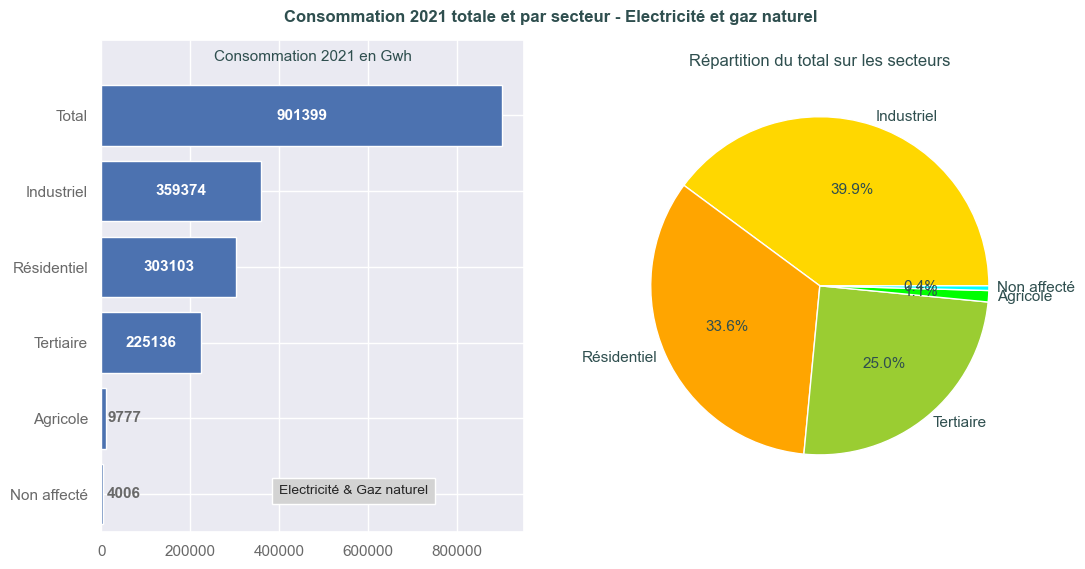

In [19]:
#Graphe 2

fig=plt.figure(figsize=(12,6))
df_total=pd.DataFrame({"Total":conso_epci_2021["conso_totale"].sum(),
                       "Résidentiel":conso_epci_2021["conso_resid"].sum(),
                       "Tertiaire":conso_epci_2021["conso_ter"].sum(),
                       "Industriel":conso_epci_2021["conso_indus"].sum(),
                       "Agricole":conso_epci_2021["conso_agri"].sum(),
                       "Non affecté":conso_epci_2021["conso_nonaff"].sum()
                      },index=[0])

df_total=df_total.T.reset_index(drop=False)
df_total=df_total.rename({"index":"Secteur",0:"Consommation en Gwh"},axis=1)
df_total=df_total.sort_values(by="Consommation en Gwh",ascending=True)

graf=plt.subplot(1,2,1)
graf.barh(df_total["Secteur"],df_total["Consommation en Gwh"])
i=-1
for p in graf.patches: 
        i+=1
        val=p.get_width()
        if i>=2:    
            graf.text(val/2,i,
             '{}'.format(int(val)), fontsize=11,weight="bold",color='white',ha='center',va='center')
        else:
            graf.text(val/2+10000,i,
                '{}'.format(int(val)), fontsize=11,weight="bold",color='dimgray',ha='left',va='center')


plt.title("Consommation 2021 en Gwh",color=couleur_texte,size=11,pad=-15)

texte="Electricité & Gaz naturel"
plt.text(400000,0,texte,fontweight = 'light', bbox={'facecolor': 'lightgrey', 'alpha': 1, 'pad': 5} ,size=10);
plt.xticks(color=couleur_axes,size=11)
plt.xlabel("")
plt.xlim([0,950000])
plt.yticks(color=couleur_axes,size=11)
plt.ylim([-0.5,6])
plt.ylabel("");

plt.subplot(1,2,2)
df_pie=df_total[df_total["Secteur"]!="Total"]
df_pie=df_pie.merge(right=df_sect_couleurs,on="Secteur",how="left")
df_pie=df_pie.sort_values(by="Consommation en Gwh",ascending=False).reset_index(drop=True)
labelx=df_pie["Secteur"]
def func(pct, valeurs):
    #absolute = int(np.round(pct/100.*np.sum(valeurs)))
    return f"{pct:.1f}%"

valeurs=df_pie["Consommation en Gwh"]
plt.pie(valeurs,labels=df_pie["Secteur"],colors=df_pie["Couleur"],
         autopct=lambda pct: func(pct, valeurs),labeldistance=1.05,startangle=0,
         pctdistance=0.60,textprops={"size":11,"color":couleur_texte})
plt.title("Répartition du total sur les secteurs",color=couleur_texte,size=12)

plt.subplots_adjust(top=0.93)
plt.suptitle("Consommation 2021 totale et par secteur - Electricité et gaz naturel",color=couleur_texte,size=12,weight="bold");

#Image
fig.savefig("énergie_graphe_2") 

In [20]:
#Graphes de la consommation totale par type d'EPCI et secteur

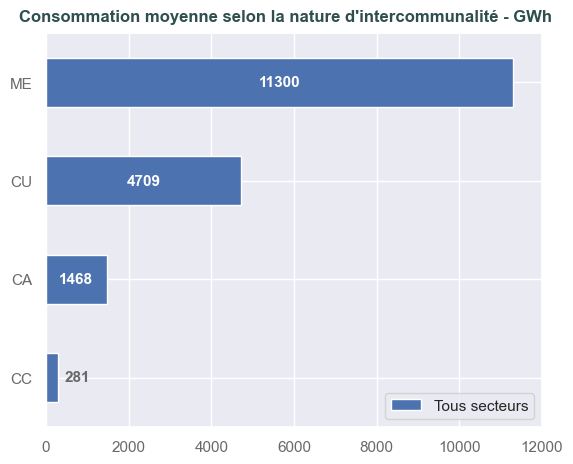

In [21]:
#Graphe 3
#Consommation en GWH par nature d'EPCI
df_nature_epci=conso_epci_2021.groupby(["nature_epci"],as_index=False).agg({'conso_totale':"mean",'conso_agri':"mean", 'conso_ter':"mean",
       'conso_indus':"mean", 'conso_resid':'mean', 'conso_nonaff':"mean"})

df_nature_epci=df_nature_epci.rename({'conso_totale':"Tous secteurs",'conso_agri':"Agricole", 'conso_ter':"Tertiaire",
       'conso_indus':"Industriel", 'conso_resid':'Résidentiel', 'conso_nonaff':"Non affecté"},axis=1)

df_nature_epci=df_nature_epci.set_index("nature_epci")
df_nature_epci=df_nature_epci.reindex(["CC","CA","CU","ME"])
df_nature_epci=df_nature_epci.reset_index(drop=False)

fig=plt.figure()
ax=fig.subplots()
couleurs=["orange","yellowgreen","gold","lime","cyan"]

df_nature_epci.plot.barh(x="nature_epci",y="Tous secteurs",rot=0,ax=ax)
i=-1
for p in ax.patches: 
        i+=1
        val=p.get_width()
        if i>=1:    
            ax.text(val/2,i,
             '{}'.format(int(val)), fontsize=11,weight="bold",color='white',ha='center',va='center')
        else:
            ax.text(val/2+300,i,
                '{}'.format(int(val)), fontsize=11,weight="bold",color='dimgray',ha='left',va='center')

plt.title("")
plt.xlim([0,12000])
plt.xticks(color=couleur_axes,size=11)
plt.yticks(color=couleur_axes,size=11)
plt.ylim([-0.5,3.5])
plt.ylabel("");

plt.subplots_adjust(top=0.93)
plt.suptitle("Consommation moyenne selon la nature d'intercommunalité - GWh",color=couleur_texte,size=12,weight="bold");


#1-Ce graphe suggère des répartitions entre secteurs différentes selon la nature d' epci
#2-On note des totaux ME/CA/CC pas très différents alors que les nombres d'epci correspondants sont très
#différents

#Image
fig.savefig("énergie_graphe_3") 

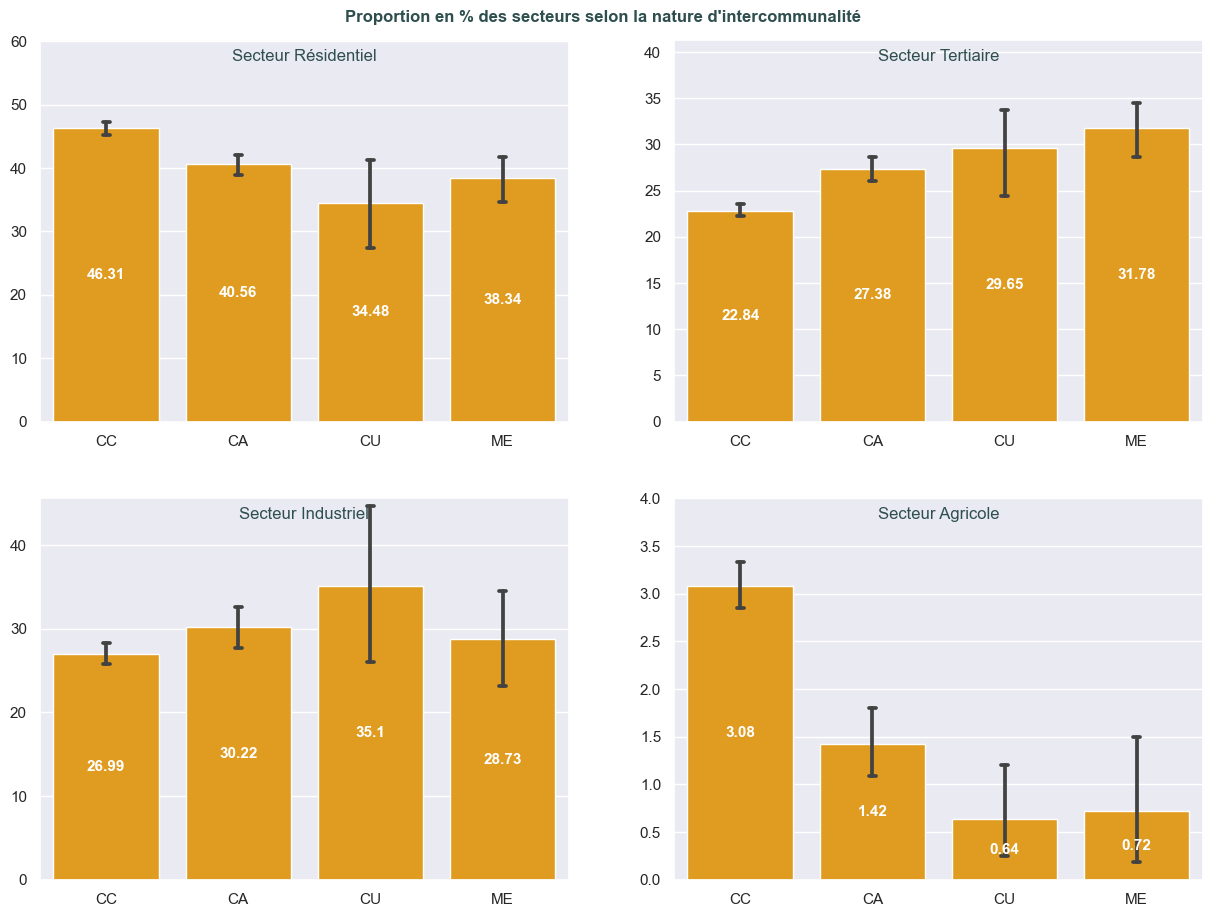

In [22]:
#Graphe 4 - proportion des sevteurs en fonction de la nature d'epci
fig, ax = plt.subplots(figsize=(15,10))
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_axis_off()
nb_rg=2
nb_col=2
df=conso_epci_2021
variables=['r_resid', 'r_ter', 'r_indus', 'r_agri', 'r_nonaff'] 

for i in range(4):
    ax = fig.add_subplot(nb_rg, nb_col, i+1)
    var=variables[i]
    sns.barplot(data=df,x="nature_epci",y=var,color="orange",ax=ax,errorbar="ci",capsize=0.05,order=ordre_epci)
    titre ="Secteur " +str(df_defsecteur[df_defsecteur["ratio"]==var].iat[0,1])
    ax.set_title(titre,fontdict={'fontsize':12,'color':couleur_texte},pad=-15)
    plt.xlabel("")
    plt.ylabel("")
    ech=0
    for p in ax.patches: 
        val=p.get_height()
        if val>ech:
            ech=val
        ax.text(p.get_x()+ p.get_width()/2.,
            val/2,
            '{}'.format(val.round(2)), 
            fontsize=11,weight="bold",
            color='white',
            ha='center',
            va='center')
    ech*=1.3
    plt.ylim([0,ech])
                       
plt.subplots_adjust(top=0.95)
plt.suptitle("Proportion en % des secteurs selon la nature d'intercommunalité",color=couleur_texte,size=12,weight="bold");
#graphe 9

#Sur les graphes les barres correspondent à l'intervalle de confiance à 95% sur les moyennes
#On note le fort intervalle pour les intercommunalités de type CU dans le cas du secteur industriel

#conso secteur tertiaire clairement liée à la nature d'EPCI
#conso secteur agricole : idemdans l'autre sens avec un grois écart entre CC et le reste
#conso secteur résidentiel : CC au dessus des autres

#conso secteur industriel : pas d'effet 

#prévoir si nécessaire des tests de comparaison 2 à 2

#Image
fig.savefig("énergie_graphe_4") 

In [23]:
#vérification statistique anova
#Test de anova des r_secteurs vs nature epci

df=conso_epci_2021
variables=['r_resid', 'r_ter', 'r_indus', 'r_agri', 'r_nonaff']

var_cible="num_nature_epci"
valeur_F=[]
pval=[]
for var_expl in variables:
    var_test=var_cible + "~" + var_expl
    test=ols(var_test,data=df).fit()
    anova=sm.stats.anova_lm(test)
    valeur_F.append((anova["F"][0]).round(2))
    pval.append((anova["PR(>F)"][0]).round(3))

df_anova=pd.DataFrame({"variable":variables,"valeur de F":valeur_F,"p-value":pval}) 
df_anova=df_anova.sort_values(by=["valeur de F"],ascending=False).reset_index(drop=True)


print("Résultat des anova sur la variable cible:\n")
print("Variable cible :",var_cible,"\n")
print (df_anova)    

#Conclusion : 
# Effet très net de la nature d'epci sur les 3 ratios tertiaire,agriculture et résidentiel
# Un effet mais beaucoup moins marqué sur le ratio industriel
# Aucun effet sur la partie non affectée


Résultat des anova sur la variable cible:

Variable cible : num_nature_epci 

   variable  valeur de F  p-value
0     r_ter        51.47    0.000
1    r_agri        44.19    0.000
2   r_resid        29.27    0.000
3   r_indus         3.91    0.048
4  r_nonaff         2.61    0.106


In [24]:
#Image tableau
df_tabl=df_anova
df_tabl=df_tabl.replace(to_replace=["r_resid","r_ter","r_indus","r_agri","r_nonaff"],
                       value=["Résidentiel","Tertiaire","Industriel","Agricole","Non affecté"])

variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>variable</b>","<b>valeur de F</b>","<b>p-value</b>"]
#list(df.columns)
trace = go.Table(
   columnorder=[1,2,3,4],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=550, height=500,title_text="<b>Anova :%secteur vs nature intercommunalité</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("énergie_tabl1.png")


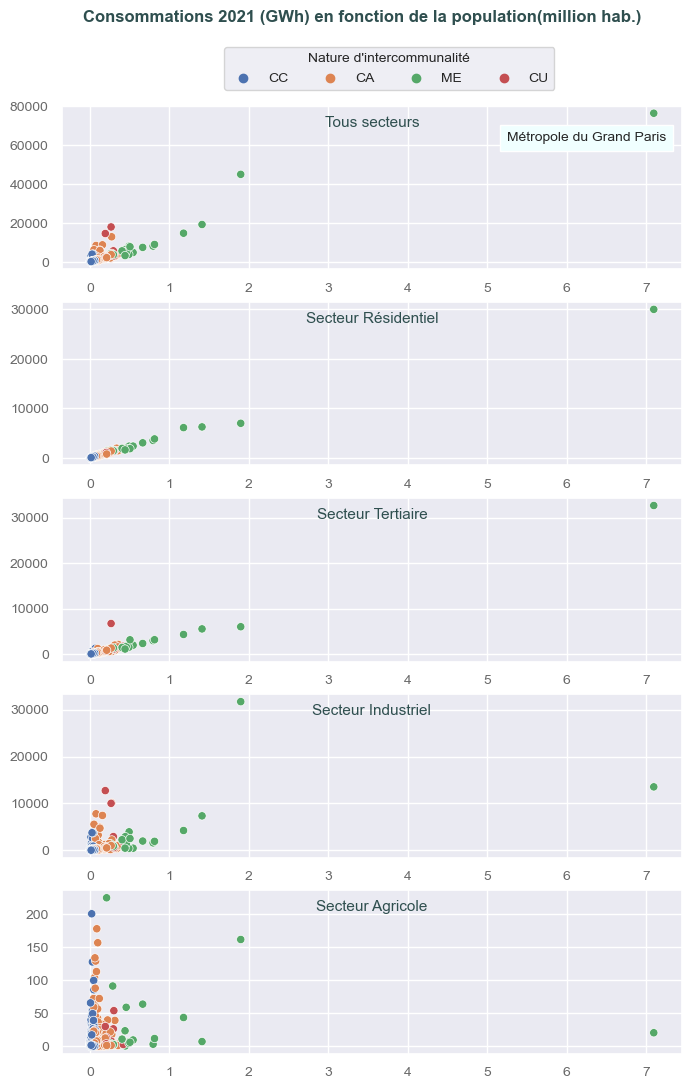

In [25]:
#Graphes globaux - les consommations en fonction de la population par nature d'epci
df=conso_epci_2021
nlig=5
ncol=1
fig,ax=plt.subplots(nlig,ncol,figsize=(8,12))
variables=["conso_totale","conso_resid","conso_ter","conso_indus","conso_agri"]
labels=["-","Résidentiel","Tertiaire","Industriel","Agricole"]
var_x="population"

for i in range(len(variables)):
    var_y=variables[i]
    k=np.int(i/ncol)
    l=np.mod(i,ncol)
    #graf=ax[k][l]
    graf=ax[k]
    if i==0:
        sns.scatterplot(df,x=var_x,y=var_y,color='#4c72b0',hue="nature_epci",ax=graf)
        sns.move_legend(graf,bbox_to_anchor=(.25, 1.40),loc="upper left", ncol=4, title="Nature d'intercommunalité",fontsize=10,
                       title_fontproperties={"size":10 })
        graf.set_title("Tous secteurs",color=couleur_texte,size=11,pad=-15)
        texte5='Métropole du Grand Paris'
        graf.text(5250000,62000,texte5,fontweight = 'light',
             bbox={'facecolor': 'azure', 'alpha': 1, 'pad': 5} ,size=10);
    else:    
        sns.scatterplot(df,x=var_x,y=var_y,color='#4c72b0',hue="nature_epci",legend=False,ax=graf)
        graf.set_title("Secteur "+labels[i],color=couleur_texte,size=11,pad=-15)
        
    graf.set_xlabel("")    
    graf.set_ylabel("")
    graf.set_xticklabels(["x","0","1","2","3","4","5","6","7"],color=couleur_axes,size=10)
    plt.draw()
    labely=[item.get_text() for item in graf.get_yticklabels(which='both')]
    graf.set_yticklabels(labely,color=couleur_axes,size=10)
    
plt.subplots_adjust(top=0.90)
plt.suptitle("Consommations 2021 (GWh) en fonction de la population(million hab.)",color=couleur_texte,size=12,weight="bold");

#Image
fig.savefig("énergie_graphe_5") 

In [26]:
#verification des correlations - pb de la distribution des populations qui n'est pas normale 
#df=conso_epci_2021[conso_epci_2021["nom_epci"]!='Métropole du Grand Paris']
df=conso_epci_2021
var_cible="population"
variables=["conso_totale","conso_resid","conso_ter","conso_indus","conso_agri"]

coeffcorr=[]
pval=[]
for var in variables:  #adapter selon variables explicatives prises en compte
    test=pearsonr(df[var_cible],df[var])
    coeffcorr.append(test[0].round(3))
    pval.append(test[1].round(4))
corr_cible=pd.DataFrame({"variable":variables,"correlation":coeffcorr,"p-value":pval}) 
corr_cible["val_abs"]=corr_cible["correlation"].abs()
corr_cible=corr_cible.sort_values(by="val_abs",ascending=False).reset_index(drop=True).drop("val_abs",axis=1).head(20) 
corr_cible

variable  correlation  p-value
0   conso_resid        0.997      0.0
1     conso_ter        0.980      0.0
2  conso_totale        0.929      0.0
3   conso_indus        0.549      0.0
4    conso_agri        0.146      0.0

In [27]:
#Image tableau correlation

df_tabl=corr_cible

df_tabl=df_tabl.replace(to_replace=["conso_totale","conso_resid","conso_ter","conso_indus","conso_agri"],
                       value=["Tous secteurs","Résidentiel","Tertiaire","Industriel","Agricole"])
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>secteur</b>","<b>correlation</b>","<b>p-value</b>"]

trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=500, height=500,title_text="<b>Corrélation entre population et consommation par secteur</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("énergie_tabl2.png")


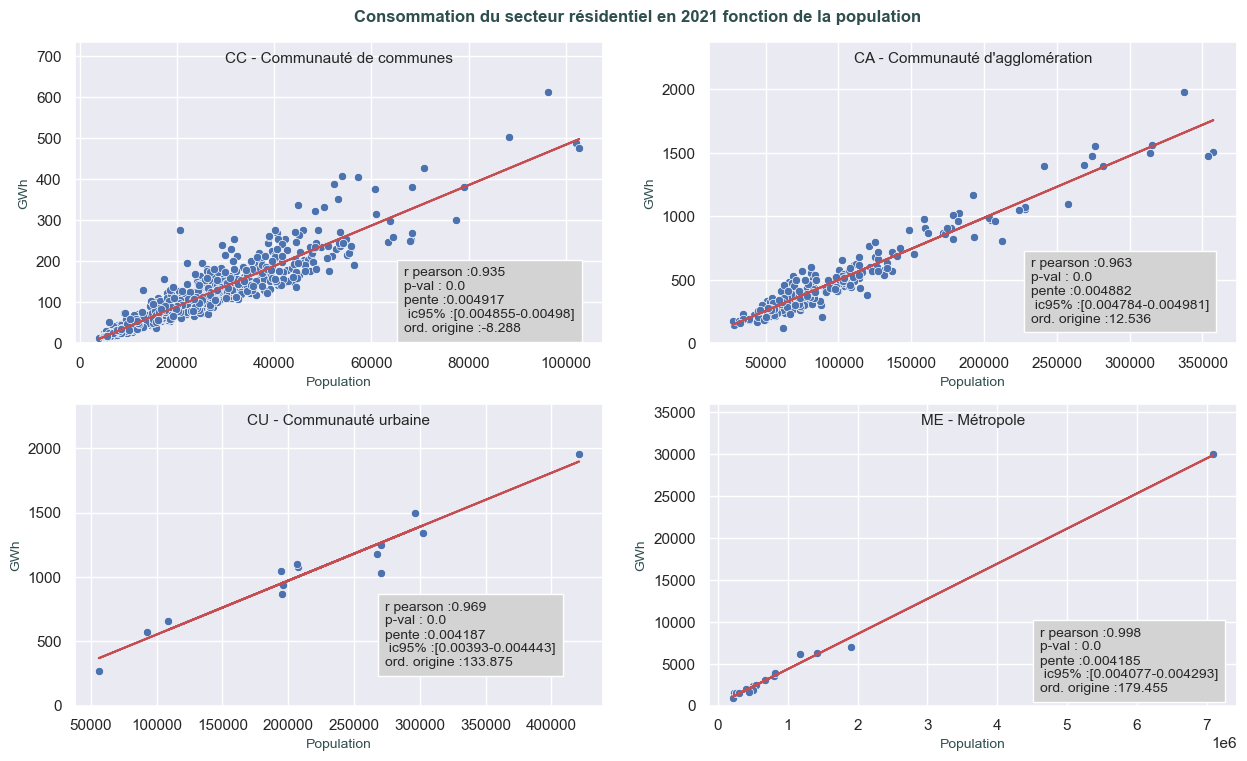

In [28]:
#Graphe avec population
#Les graphiques entre consommation du secteur résidentiel et polulation sont présentés de manière
#décomposé pour la commodité de la lecture : la métriopole du Grand-Paris et les métropoles en général écarsent tout
fig=plt.figure(figsize=(15,8))
for i in range(df_epci.shape[0]):
    plt.subplot(2,2,i+1)
    df=conso_epci_2021[conso_epci_2021["nature_epci"]==df_epci["nature_epci"][i]]
    var_x="population"
    var_y="conso_resid"
    nb_ddl=df.shape[0]-2
    sns.scatterplot(df,x=var_x,y=var_y,color='#4c72b0')
    titre=df_epci["nature_epci"][i]+" - "+df_epci["nom_nature_epci"][i]
    plt.title(titre,size=11,pad=-15)
    plt.xlabel("Population",color=couleur_texte,size=10)
    plt.ylabel("GWh",color=couleur_texte,size=10)
    plt.ylim([0,1.2*df[var_y].max()])
    #Régression linéaire
    coeffcorr,pval=pearsonr(df[var_y],df[var_x])
    reg = LinearRegression()
    x=np.array(df[var_x]).reshape(-1,1)
    y=np.array(df[var_y]).reshape(-1,1)
    reg.fit(x,y)
    ymod=reg.coef_*x+reg.intercept_
    plt.plot(x,reg.coef_*x+reg.intercept_,color='r',linewidth=1.5)
    sx=np.sqrt(np.sum(x*x))
    sy=np.sqrt((np.sum((y-ymod)*(y-ymod)))/nb_ddl)
    ic95=sy/sx*t.ppf(1-0.025,nb_ddl,0,1)
    ic95max=reg.coef_[0][0]+ic95
    ic95min=reg.coef_[0][0]-ic95
    texte1="r pearson :"+ str(coeffcorr.round(3))
    texte2="p-val : "+ str(pval.round(3))
    texte3="pente :"+ str((reg.coef_[0][0]).round(6))
    texte4=" ic95% :"+"["+str(ic95min.round(6))+"-"+str(ic95max.round(6))+"]"
    texte5="ord. origine :"+ str((reg.intercept_[0]).round(3));
    texte=texte1+"\n"+texte2+"\n"+texte3+"\n"+texte4+"\n"+texte5
    plt.text(df[var_x].max()*0.65,df[var_y].min()+(df[var_y].max()-df[var_y].min())*0.025,texte,fontweight = 'light',
             bbox={'facecolor': 'lightgrey', 'alpha': 1, 'pad': 5} ,size=10);
plt.subplots_adjust(top=0.94)
plt.suptitle("Consommation du secteur résidentiel en 2021 fonction de la population",size=12,color=couleur_texte,weight="bold");

#Modèle global
df=conso_epci_2021
var_x="population"
var_y="conso_resid"


#Image
fig.savefig("énergie_graphe_6") 

                   valeur
r pearson         0.98000
p-value           0.00000
pente             0.00444
ord.à l'origine -51.88300


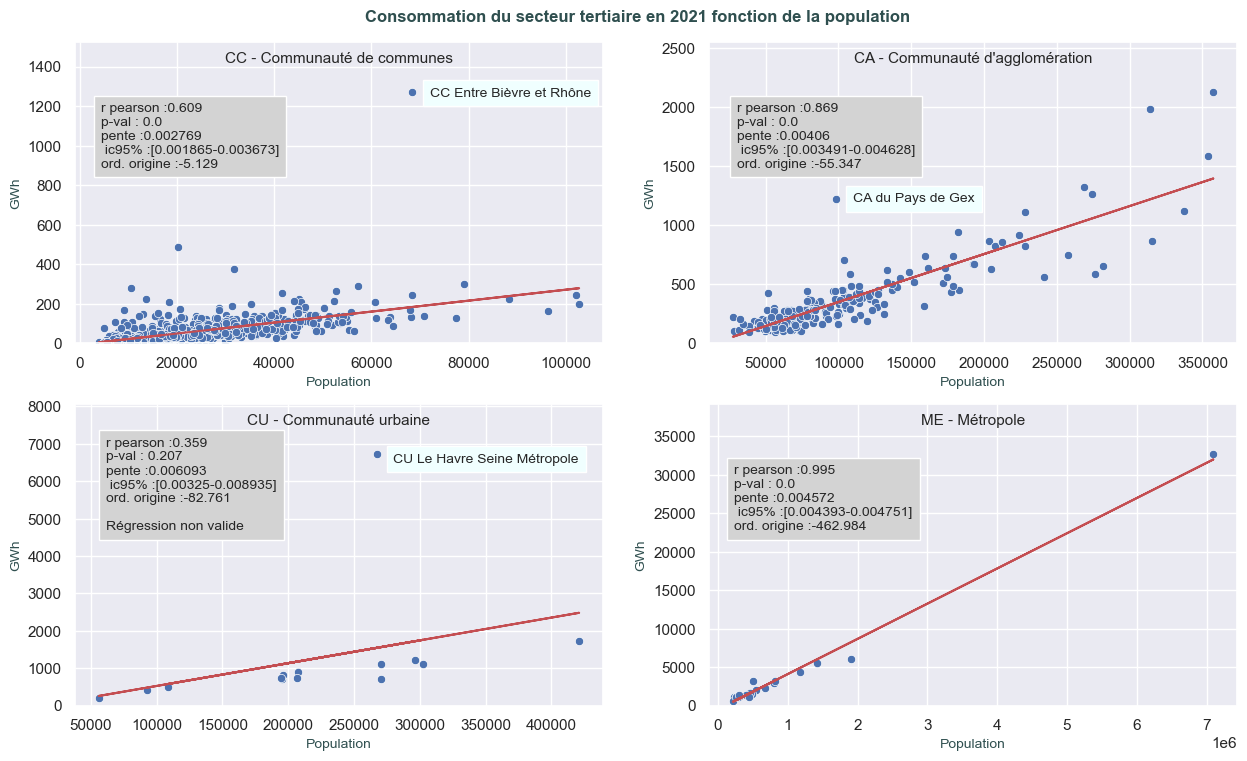

In [29]:
#Les graphiques entre consommation totale et polulation sont présentéd de manière
#décomposé pour la commodité de la lecture : la métriopole du Grand-Paris et les métropoles en général écarsent tout
fig=plt.figure(figsize=(15,8))
for i in range(df_epci.shape[0]):
    plt.subplot(2,2,i+1)
    df=conso_epci_2021[conso_epci_2021["nature_epci"]==df_epci["nature_epci"][i]]
    var_x="population"
    var_y="conso_ter"
    sns.scatterplot(df,x=var_x,y=var_y,color='#4c72b0')
    plt.ylim([0,1.2*df[var_y].max()])
    titre=df_epci["nature_epci"][i]+" - "+df_epci["nom_nature_epci"][i]
    plt.title(titre,size=11,pad=-15)
    plt.xlabel("Population",color=couleur_texte,size=10)
    plt.ylabel("GWh",color=couleur_texte,size=10)
    #Régression linéaire
    coeffcorr,pval=pearsonr(df[var_y],df[var_x])
    reg = LinearRegression()
    x=np.array(df[var_x]).reshape(-1,1)
    y=np.array(df[var_y]).reshape(-1,1)
    reg.fit(x,y)
    ymod=reg.coef_*x+reg.intercept_
    plt.plot(x,reg.coef_*x+reg.intercept_,color='r',linewidth=1.5)
    sx=np.sqrt(np.sum(x*x))
    sy=np.sqrt((np.sum((y-ymod)*(y-ymod)))/nb_ddl)
    ic95=sy/sx*t.ppf(1-0.025,nb_ddl,0,1)
    ic95max=reg.coef_[0][0]+ic95
    ic95min=reg.coef_[0][0]-ic95
    texte1="r pearson :"+ str(coeffcorr.round(3))
    texte2="p-val : "+ str(pval.round(3))
    texte3="pente :"+ str((reg.coef_[0][0]).round(6))
    texte4=" ic95% :"+"["+str(ic95min.round(6))+"-"+str(ic95max.round(6))+"]"
    texte5="ord. origine :"+ str((reg.intercept_[0]).round(3));
    texte6="Régression non valide"
    if df_epci["nature_epci"][i]=="CU":
        texte=texte1+"\n"+texte2+"\n"+texte3+"\n"+texte4+"\n"+texte5+"\n\n"+texte6
    else:    
        texte=texte1+"\n"+texte2+"\n"+texte3+"\n"+texte4+"\n"+texte5
    #    
    plt.text(df[var_x].min()*1.1,df[var_y].max()*0.7,texte,fontweight = 'light',
             bbox={'facecolor': 'lightgrey', 'alpha': 1, 'pad': 5} ,size=10);
    if df_epci["nature_epci"][i]=="CU":
        texte5="CU Le Havre Seine Métropole"
        plt.text(280000,6500,texte5,fontweight = 'light',
             bbox={'facecolor': 'azure', 'alpha': 1, 'pad': 5} ,size=10);
        texte6="Régression non valide"
    if df_epci["nature_epci"][i]=="CC":
        texte5="CC Entre Bièvre et Rhône"
        plt.text(72000,1250,texte5,fontweight = 'light',
             bbox={'facecolor': 'azure', 'alpha': 1, 'pad': 5} ,size=10); 
    if df_epci["nature_epci"][i]=="CA":
        texte5="CA du Pays de Gex"
        plt.text(110000,1200,texte5,fontweight = 'light',
             bbox={'facecolor': 'azure', 'alpha': 1, 'pad': 5} ,size=10);     
    plt.subplots_adjust(top=0.94)
plt.suptitle("Consommation du secteur tertiaire en 2021 fonction de la population",size=12,color=couleur_texte,weight="bold");

#Modèle global
df=conso_epci_2021
var_x="population"
var_y="conso_ter"

coeffcorr,pval=pearsonr(df[var_y],df[var_x])
reg = LinearRegression()
x=np.array(df[var_x]).reshape(-1,1)
y=np.array(df[var_y]).reshape(-1,1)
reg.fit(x,y)
r=coeffcorr.round(3)
p_val=pval.round(3)
pente=reg.coef_[0][0].round(6)
ord_orig=reg.intercept_[0].round(3)

df_reg_globale=pd.DataFrame({"r pearson":r,"p-value":p_val,"pente":pente,"ord.à l'origine":ord_orig},index=["valeur"])
print(df_reg_globale.T)

#Image
fig.savefig("énergie_graphe_7") 

In [30]:
#2 cas particuliers à analyser à partir du fichier de détail
#CU Le Havre Seine Métropole
#CC Entre Bièvre et Rhône  ,CC Porte du Jura

In [31]:
verif_CU=conso_communes_2021[conso_communes_2021["nom_epci"]=="CU Le Havre Seine Métropole"]
verif_CU[["code_commune","libelle_commune","conso_totale","conso_resid","conso_ter"]].sort_values(by="conso_ter",ascending=False).head(5)

code_commune       libelle_commune  conso_totale    conso_resid  \
371790        76305  Gonfreville-l'Orcher  1.383800e+07   32791.295186   
371833        76351              Le Havre  2.380429e+06  703071.063410   
372129        76660           Sandouville  5.640894e+05    3111.253883   
371927        76447         Montivilliers  1.719490e+05   78710.556432   
371823        76341              Harfleur  7.880021e+04   36756.883256   

           conso_ter  
371790  5.692371e+06  
371833  7.304530e+05  
372129  6.980070e+04  
371927  6.216915e+04  
371823  2.454310e+04

In [32]:
verif_CC=conso_communes_2021[conso_communes_2021["nom_epci"]=="CC Entre Bièvre et Rhône"]
verif_CC[["code_commune","libelle_commune","conso_totale","conso_resid","conso_ter"]].sort_values(by="conso_ter",ascending=False).head(5)

code_commune         libelle_commune  conso_totale   conso_resid  \
356674        38468       Salaise-sur-Sanne  1.828333e+06  21344.308960   
356279        38034             Beaurepaire  1.472531e+05  19767.095940   
356558        38344              Roussillon  1.321346e+05  34296.304210   
356517        38298  Le Péage-de-Roussillon  4.383733e+04  23582.965841   
356635        38425    Saint-Maurice-l'Exil  4.744078e+04  27293.061969   

           conso_ter  
356674  1.142828e+06  
356279  2.830348e+04  
356558  2.003059e+04  
356517  1.929646e+04  
356635  1.440250e+04

In [33]:
#On décide d'ajouter des indicateurs rapportés à la population en MWh par hab
#Objectif décorréler autant que possible de la population et de la nature de 'EPCI'
variables=["conso_totale","conso_resid","conso_ter","conso_indus","conso_agri"]
for var in variables:
    var1=var.split("_")[1]+"_hab"
    conso_epci_2021[var1]=1000*conso_epci_2021[var]/conso_epci_2021["population"]
        

In [34]:
#Description statistique rapide des nouvelles variables    
conso_epci_2021[["totale_hab","resid_hab","ter_hab","indus_hab","agri_hab"]].describe()

#2 variables ont des valeurs qui vont au-delà de 30 MWh/hab : le total et le secteur industriel
#On se doute que le total par habitant est corrélé à l'industriel par habitant
#par construction

#Les distributions ne sont pas de type "normal".On les explicitera dans deux cas

totale_hab    resid_hab      ter_hab    indus_hab     agri_hab
count  1231.000000  1231.000000  1231.000000  1231.000000  1231.000000
mean     12.838940     4.497579     2.690356     5.291179     0.267213
std      12.686286     1.028150     2.062547    12.007134     0.453062
min       3.839207     1.901206     0.443531     0.019850     0.000000
25%       7.377408     3.793795     1.561598     0.827814     0.061704
50%      10.203659     4.359193     2.262713     2.173955     0.150227
75%      13.412266     4.991465     3.303765     4.959130     0.329135
max     205.847641    13.364929    26.573566   194.257443     8.544908

In [35]:
#Image du tableau
df_tableau=conso_epci_2021[["totale_hab","resid_hab","ter_hab","indus_hab","agri_hab"]].describe().reset_index(drop=False)
df_tableau=df_tableau.replace(to_replace=["count","mean"],value=["nombre","moyenne"])
#Mise au format
for var in list(df_tableau.columns):
    if var !="index":
        df_tableau[var]=df_tableau[var].apply(lambda x: np.round(x,3))

variable=[df_tableau[var] for var in df_tableau.columns]    
entêtes=["<b>Paramètre</b>","<b>Total</b>","<b>Résidentiel</b>",
         "<b>Tertiaire</b>","<b>Industriel</b>","<b>Agricole</b>"]
#list(df.columns)
trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=800, height=500,title_text="<b>Statistiques descriptives des consommations par habitant en MWh/hab.</b>",
                  title_x=0.5,title_y=0.85,font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("énergie_tabl3.png")


In [36]:
#verification des correlations vis à vis de la population pour cette nouvelle série de variables
df=conso_epci_2021
var_cible="population"
variables=["totale_hab","resid_hab","ter_hab","indus_hab","agri_hab"]

coeffcorr=[]
pval=[]
for var in variables:  #adapter selon variables explicatives prises en compte
    test=pearsonr(df[var_cible],df[var])
    coeffcorr.append(test[0].round(3))
    pval.append(test[1].round(3))
corr_cible=pd.DataFrame({"variable":variables,"correlation":coeffcorr,"p-value":pval}) 
corr_cible["val_abs"]=corr_cible["correlation"].abs()
corr_cible=corr_cible.sort_values(by="val_abs",ascending=False).reset_index(drop=True) 
corr_cible.drop("val_abs",axis=1).head(20)

#on a bien éliminé les corrélations

variable  correlation  p-value
0     ter_hab        0.088    0.002
1    agri_hab       -0.061    0.033
2   resid_hab        0.036    0.202
3  totale_hab        0.019    0.512
4   indus_hab        0.005    0.875

In [37]:
#Image tableau correlation

df_tabl=corr_cible.drop("val_abs",axis=1).head(20)

df_tabl=df_tabl.replace(to_replace=["totale_hab","resid_hab","ter_hab","indus_hab","agri_hab"],
                       value=["Tous secteurs","Résidentiel","Tertiaire","Industriel","Agricole"])

#Mise au format
for var in list(df_tabl.columns[2:]):
    df_tabl[var]=df_tabl[var].apply(lambda x: np.round(x,3))
    
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>secteur 1</b>","<b>correlation</b>","<b>p-value</b>"]

trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=500, height=500,title_text="<b>Consommation par habitant et par secteur<br />Corrélation avec population</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("énergie_tabl4.png")

In [38]:
#Anova versus nature_EPCI

df=conso_epci_2021
variables=["totale_hab","resid_hab","ter_hab","indus_hab","agri_hab"]

var_cible="num_nature_epci"
valeur_F=[]
pval=[]
for var_expl in variables:
    var_test=var_cible + "~" + var_expl
    test=ols(var_test,data=df).fit()
    anova=sm.stats.anova_lm(test)
    valeur_F.append(anova["F"][0])
    pval.append(anova["PR(>F)"][0])

df_anova=pd.DataFrame({"variable":variables,"valeur de F":valeur_F,"p-value":pval}) 
df_anova=df_anova.sort_values(by=["valeur de F"],ascending=False).reset_index(drop=True)


print("Résultat des anova sur la variable cible:\n")
print("Variable cible :",var_cible,"\n")
print (df_anova)   

#On doit rejeter l'hypothèse d'un effet de la naturee de l'EPCI sur la variable indus_hab

Résultat des anova sur la variable cible:

Variable cible : num_nature_epci 

     variable  valeur de F       p-value
0     ter_hab    62.844034  4.988145e-15
1   resid_hab    46.861652  1.199755e-11
2    agri_hab    15.874723  7.165401e-05
3  totale_hab     6.955118  8.463418e-03
4   indus_hab     1.126611  2.887078e-01


In [39]:
#Corrélation entre les variables secteur
df=conso_epci_2021
variables=["totale_hab","resid_hab","ter_hab","indus_hab","agri_hab"]

variable1=[]
variable2=[]
coeffcorr=[]
pval=[]
sign_95=[]
for i in range(len(variables)):
    for j in np.arange(i+1,len(variables),1):
            variable1.append(variables[i])
            variable2.append(variables[j])
            test=pearsonr(df[variables[i]],df[variables[j]])
            coeffcorr.append(test[0])
            pval.append(test[1])
            if test[1]<0.05:
                sign_95.append("oui")
            else:
                sign_95.append("non")
            
corr_var=pd.DataFrame({"variable 1":variable1,"variable 2":variable2,"correlation":coeffcorr,"p-value":pval,"significatif":sign_95}) 
corr_var["val_abs"]=corr_var["correlation"].abs()
corr_var=corr_var.sort_values(by="val_abs",ascending=False).reset_index(drop=True) 
corr_var=corr_var.drop("val_abs",axis=1).head(5)
corr_var

variable 1 variable 2  correlation       p-value significatif
0  totale_hab  indus_hab     0.978793  0.000000e+00          oui
1   resid_hab    ter_hab     0.307908  1.917417e-28          oui
2  totale_hab    ter_hab     0.296648  1.986161e-26          oui
3  totale_hab  resid_hab     0.227099  7.298363e-16          oui
4   resid_hab   agri_hab    -0.177310  3.742464e-10          oui

In [40]:
#Image tableau correlation

df_tabl=corr_var.drop("significatif",axis=1)

df_tabl=df_tabl.replace(to_replace=["totale_hab","resid_hab","ter_hab","indus_hab","agri_hab"],
                       value=["Tous secteurs","Résidentiel","Tertiaire","Industriel","Agricole"])

#Mise au format
for var in list(df_tabl.columns[2:]):
    df_tabl[var]=df_tabl[var].apply(lambda x: np.round(x,3))
    
variable=[df_tabl[var] for var in df_tabl.columns]    
entêtes=["<b>secteur 1</b>","<b>secteur 2</b>","<b>correlation</b>","<b>p-value</b>"]

trace = go.Table(
   columnorder=[1,2,3,4,5,6],
   header = dict(
       values = entêtes,
       font=dict(color='dimgray', size=13,family="Arial"),
       height=30,
       line_color='darkslategray',
       fill_color='lightgray',
       align='center'
   ),
   cells = dict(
       values =variable ,
       font=dict(color='dimgray'),
       line_color='darkslategray',
       fill_color='whitesmoke',
       align='center'
   )
)   
tableau = [trace]
fig = go.Figure(data = tableau )
fig.update_layout(width=600, height=500,title_text="<b>Corrélation entre secteurs - Consommation par habitant</b>",title_x=0.5,title_y=0.85,
                 font=dict(color='dimgray', size=10))
fig.update_traces(cells_font=dict( size=12))
fig.show()

fig.write_image("énergie_tabl5.png")

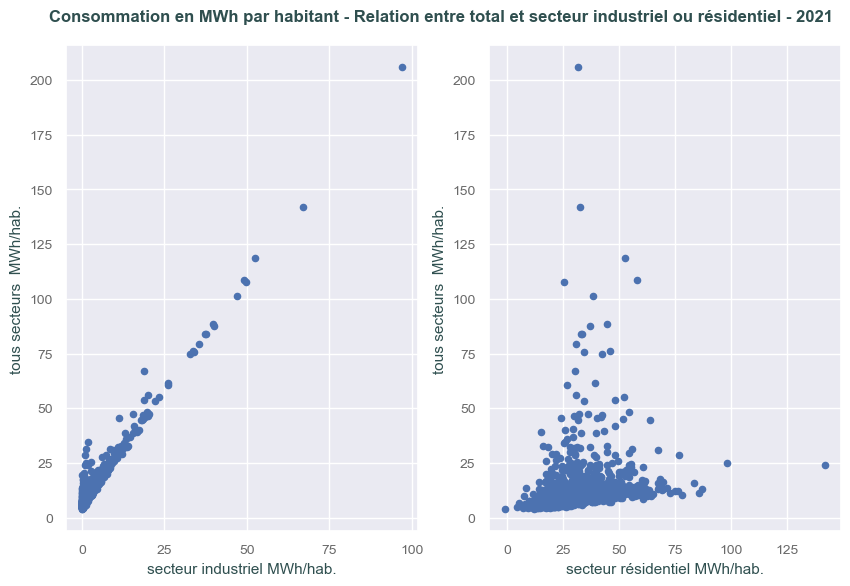

In [41]:
#Graphesde relation entre total par habitant et résidentiel ou industriel par habitant
fig,ax=plt.subplots(1,2,figsize=(10,6))

variables=["indus_hab","resid_hab"]
label_axe_x=["secteur industriel MWh/hab.","secteur résidentiel MWh/hab."]
for i in range(2):
    df.plot.scatter(x=variables[i],y="totale_hab",ax=ax[i])
    ax[i].set_xlabel(label_axe_x[i],size=11,color=couleur_texte)
    ax[i].set_ylabel("tous secteurs  MWh/hab.",size=11,color=couleur_texte)
    plt.draw()
    labely=[item.get_text() for item in ax[i].get_yticklabels(which='both')]
    ax[i].set_yticklabels(labely,color=couleur_axes,size=10)
    labexy=[item.get_text() for item in ax[i].get_xticklabels(which='both')]
    ax[i].set_xticklabels(labely,color=couleur_axes,size=10)
#    
plt.subplots_adjust(top=0.92)
plt.suptitle("Consommation en MWh par habitant - Relation entre total et secteur industriel ou résidentiel - 2021",
             size=12,color=couleur_texte,weight="bold");

#Image
fig.savefig("énergie_graphe_8") 

In [42]:
#Distribution residentiel/habitant
#Recherche de la distribution optimale
liste_distrib=[norm,lognorm ,genlogistic,pareto , genpareto ,weibull_min]
donnees=conso_epci_2021["resid_hab"]
param_est=[distr.fit(donnees)  for distr in liste_distrib]

résultats=[distr.logpdf(donnees,*params).sum() for distr,params in zip(liste_distrib,param_est)]

best_distr=liste_distrib[np.argmax(résultats)]
best_params=param_est[np.argmax(résultats)]

print("La meilleure distribution est: ",best_distr)
print("Les meilleurs paramètres de la distribution sont: ",best_params)

La meilleure distribution est:  <scipy.stats._continuous_distns.genlogistic_gen object at 0x000001A665E93400>
Les meilleurs paramètres de la distribution sont:  (7.659947342514572, 2.5821807775425056, 0.7514282920564599)


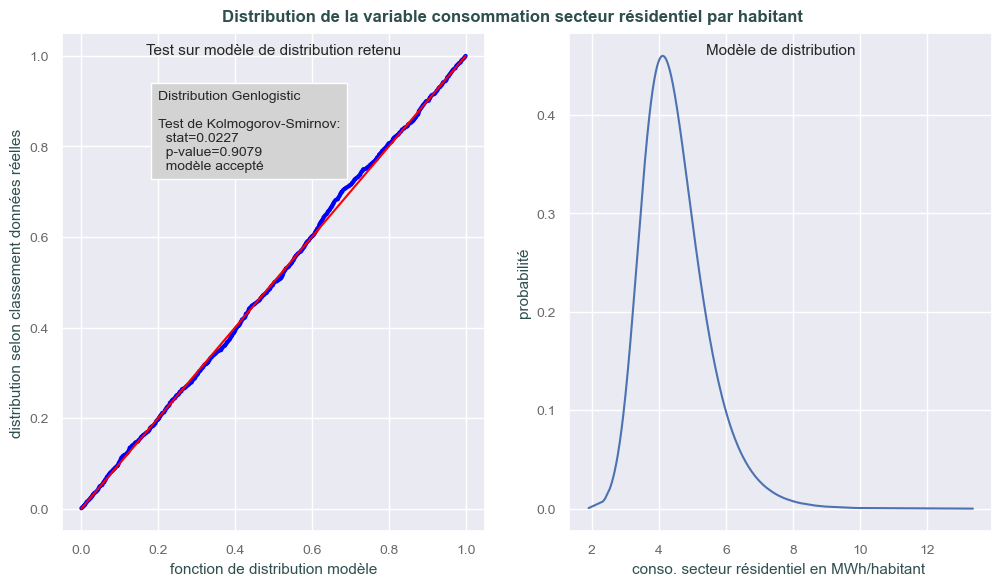

In [43]:
#Mise en graphique distribution résidentiel/habitant
var="resid_hab"
df=conso_epci_2021[[var]]
nb_val=df.shape[0]
titre="Distribution de la variable consommation secteur résidentiel par habitant"

df=df.sort_values(by=var,ascending=True).reset_index(drop=True)
df["classement"]=(1+df.index)/nb_val

#genlogistic :3ième distribution testée
sig=param_est[2][0]
orig=param_est[2][1]
échelle=param_est[2][2]

df["modele"]=df[var].apply(lambda x: genlogistic.cdf(x,sig,orig,échelle))
df["modele_2"]=df[var].apply(lambda x: genlogistic.pdf(x,sig,orig,échelle))

#Test de Kolmogorov-Smirnov
#Hypothèse nulle : les 2 distributions empirique et modélisée suivent la même loi
x=list(df["classement"])
y=list(df["modele"])
res_testKS=kstest(x,y)

#acceptation ou rejet de l'hypothèse
fig=plt.figure(figsize=(12,6))

fig1=plt.subplot(1,2,1)
plt.title("Test sur modèle de distribution retenu",size=11,pad=-15)
plt.plot(df["modele"],df["classement"],color="blue",linewidth=3,)
plt.xticks(color=couleur_axes,rotation=0,size=10)
plt.yticks(color=couleur_axes,rotation=0,size=10)
plt.xlabel("fonction de distribution modèle",color=couleur_texte,size=11)
plt.ylabel("distribution selon classement données réelles",color=couleur_texte,size=11)
plt.plot(df["modele"],df["modele"],color="red") #droite 
texte1="Distribution "+"Genlogistic"
texte2="Test de Kolmogorov-Smirnov:"
texte3="  stat="+str(np.round(res_testKS[0],4))
texte4="  p-value="+str(np.round(res_testKS[1],4))
if res_testKS[1]<0.05:
    texte5="  modèle rejeté"
else:
    texte5="  modèle accepté"
texte=texte1+"\n\n"+texte2+"\n"+texte3+"\n"+texte4+"\n"+texte5

plt.text(0.2,0.75,texte,fontweight = 'light', bbox={'facecolor': 'lightgrey', 'alpha': 1, 'pad': 5} ,size=10);


fig2=plt.subplot(1,2,2)
plt.plot(df["resid_hab"],df["modele_2"])
plt.title("Modèle de distribution",size=11,pad=-15)
plt.xticks(color=couleur_axes,rotation=0,size=10)
plt.yticks(color=couleur_axes,rotation=0,size=10)
plt.xlabel("conso. secteur résidentiel en MWh/habitant ",color=couleur_texte,size=11)
plt.ylabel("probabilité",color=couleur_texte,size=11)

plt.subplots_adjust(top=0.94)
plt.suptitle(titre,color=couleur_texte,size=12,weight="bold");

#Image
fig.savefig("énergie_graphe_9") 

In [44]:
#Distribution industriel/habitant
#Recherche de la distribution optimale
liste_distrib=[norm,lognorm ,genlogistic,pareto , genpareto ,weibull_min]
donnees=conso_epci_2021["indus_hab"]
param_est=[distr.fit(donnees)  for distr in liste_distrib]

résultats=[distr.logpdf(donnees,*params).sum() for distr,params in zip(liste_distrib,param_est)]

best_distr=liste_distrib[np.argmax(résultats)]
best_params=param_est[np.argmax(résultats)]

print("La meilleure distribution est: ",best_distr)
print("Les meilleurs paramètres de la distribution sont: ",best_params)

La meilleure distribution est:  <scipy.stats._continuous_distns.lognorm_gen object at 0x000001A665EEDA20>
Les meilleurs paramètres de la distribution sont:  (1.3321250146147814, 0.007014748800774285, 2.077756898812594)


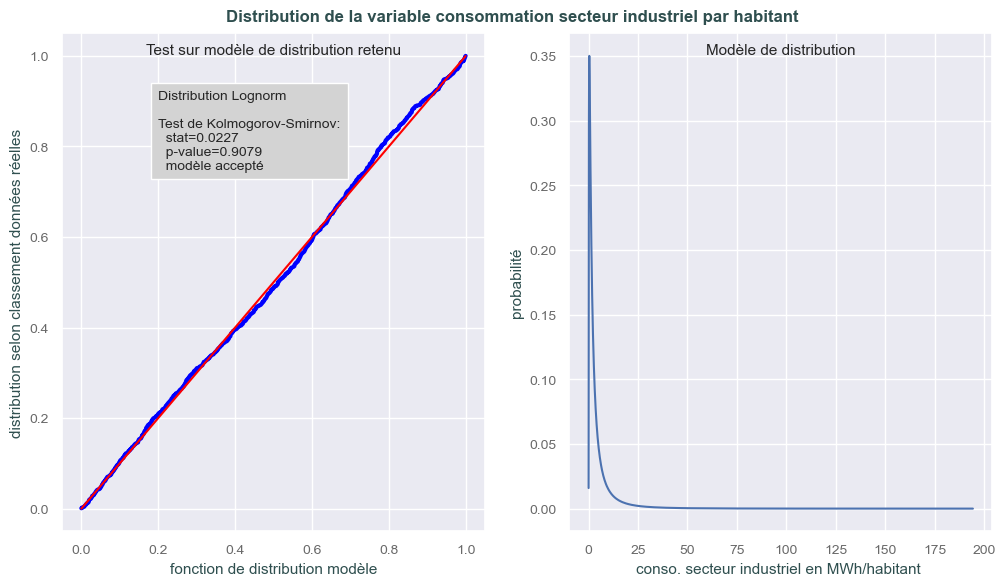

In [45]:
#Mise en graphique distribution industriel/habitant
var="indus_hab"
df=conso_epci_2021[[var]]
nb_val=df.shape[0]
titre="Distribution de la variable consommation secteur industriel par habitant"

df=df.sort_values(by=var,ascending=True).reset_index(drop=True)
df["classement"]=(1+df.index)/nb_val

#lognorm :2ième distribution testée
sig=param_est[1][0]
orig=param_est[1][1]
échelle=param_est[1][2]

df["modele"]=df[var].apply(lambda x: lognorm.cdf(x,sig,orig,échelle))
df["modele_2"]=df[var].apply(lambda x: lognorm.pdf(x,sig,orig,échelle))

#Test de Kolmogorov-Smirnov
#Hypothèse nulle : les 2 distributions empirique et modélisée suivent la même loi
x=list(df["classement"])
y=list(df["modele"])
res_testKS=kstest(x,y)

#acceptation ou rejet de l'hypothèse
fig=plt.figure(figsize=(12,6))

fig1=plt.subplot(1,2,1)
plt.title("Test sur modèle de distribution retenu",size=11,pad=-15)
plt.plot(df["modele"],df["classement"],color="blue",linewidth=3,)
plt.xticks(color=couleur_axes,rotation=0,size=10)
plt.yticks(color=couleur_axes,rotation=0,size=10)
plt.xlabel("fonction de distribution modèle",color=couleur_texte,size=11)
plt.ylabel("distribution selon classement données réelles",color=couleur_texte,size=11)
plt.plot(df["modele"],df["modele"],color="red") #droite 
texte1="Distribution "+"Lognorm"
texte2="Test de Kolmogorov-Smirnov:"
texte3="  stat="+str(np.round(res_testKS[0],4))
texte4="  p-value="+str(np.round(res_testKS[1],4))
if res_testKS[1]<0.05:
    texte5="  modèle rejeté"
else:
    texte5="  modèle accepté"
texte=texte1+"\n\n"+texte2+"\n"+texte3+"\n"+texte4+"\n"+texte5

plt.text(0.2,0.75,texte,fontweight = 'light', bbox={'facecolor': 'lightgrey', 'alpha': 1, 'pad': 5} ,size=10);


fig2=plt.subplot(1,2,2)
plt.plot(df["indus_hab"],df["modele_2"])
plt.title("Modèle de distribution",size=11,pad=-15)
plt.xticks(color=couleur_axes,rotation=0,size=10)
plt.yticks(color=couleur_axes,rotation=0,size=10)
plt.xlabel("conso. secteur industriel en MWh/habitant ",color=couleur_texte,size=11)
plt.ylabel("probabilité",color=couleur_texte,size=11)

plt.subplots_adjust(top=0.94)
plt.suptitle(titre,color=couleur_texte,size=12,weight="bold");

#Image
fig.savefig("énergie_graphe_10") 

In [46]:
#récupération des contours epci
contour_epci=gpd.read_file("C:\DATA\contours_cartes\contour_epci_simplifié.geojson")


In [47]:
#Sélection de colonnes et croisement avec des données sélectionnées
contour_epci=contour_epci[["code_epci","geometry"]]

#Données sélectionnées
df=conso_epci_2021[["code_epci","nom_epci","population","totale_hab","resid_hab","ter_hab","indus_hab","agri_hab"]]

#croisement
df_carte=contour_epci.merge(right=df,on="code_epci",how="left")

In [48]:
#Ajout de classes pour les 3 cartes

couleurs=["lightgray","lightskyblue","plum","greenyellow","yellowgreen","gold","orangered"]

nomclasse_1=["1 - moins de 5 ","2 - de 5 à 10","3 - de 10 à 15", "4 - de 15 à 25","5 - de 25 à 50",
             "6 - de 80 à 100","7 - de 100 à 205"]
labelclasse_1=list(["moins de 5 ","de 5 à 10","de 10 à 15", "de 15 à 25","de 25 à 50","de 80 à 100","de 100 à 205"])
classe_1=[-10,5,10,15,25,50,100,1000]

nomclasse_2=["1 - moins de 2 ","2 - de 2 à 4","3 - de 4 à 6","4 - de 6 à 8","5 - de 8 à 10","6 - de 10 à 12","7 - de 12 à 14"]
classe_2=[-10,2,4,6,8,10,12,100]

nomclasse_3=["1 - moins de 2 ","2 - de 2 à 4","3 - de 4 à 6","4 - de 6 à 8","5 - de 8 à 10","6 - de 10 à 12","7 - de 12 à 14"]
classe_3=[-10,2,4,6,8,10,12,100]


nomclasse_4=["1 - moins de 2 ","2 - de 2 à 4","3 - de 4 à 8","4 - de 8 à 16","5 - de 16 à 50","6 - de 50 à 100","7 -de 100 à 200"]
classe_4 =[-10,2,4,8,16,50,100,1000]

nomclasse_5=["1 - moins de 0.5 ","2 - de 0.5 à 1","3 - de 1 à 2","4 - de 2 à 4","5 - de 4 à 6","6 - de 6 à 8","7 - de 8 à 10"]
classe_5 =[-10,0.5,1,2,4,6,8,1000]


couleurs=["lightgray","lightskyblue","plum","greenyellow","yellowgreen","gold","orangered"]

df_carte["classe_totale_hab"]=pd.cut(df_carte["totale_hab"],bins=classe_1,labels=nomclasse_1)
df_carte["classe_resid_hab"]=pd.cut(df_carte["resid_hab"],bins=classe_2,labels=nomclasse_2)
df_carte["classe_ter_hab"]=pd.cut(df_carte["ter_hab"],bins=classe_3,labels=nomclasse_3)
df_carte["classe_indus_hab"]=pd.cut(df_carte["indus_hab"],bins=classe_4,labels=nomclasse_4)
df_carte["classe_agri_hab"]=pd.cut(df_carte["agri_hab"],bins=classe_5,labels=nomclasse_5)


df_carte_1=df_carte[[ 'geometry', 'nom_epci','classe_totale_hab']]
df_carte_2=df_carte[[ 'geometry', 'nom_epci','classe_resid_hab']]
df_carte_3=df_carte[[ 'geometry', 'nom_epci','classe_ter_hab']]
df_carte_4=df_carte[[ 'geometry', 'nom_epci','classe_indus_hab']]
df_carte_5=df_carte[[ 'geometry', 'nom_epci','classe_agri_hab']]


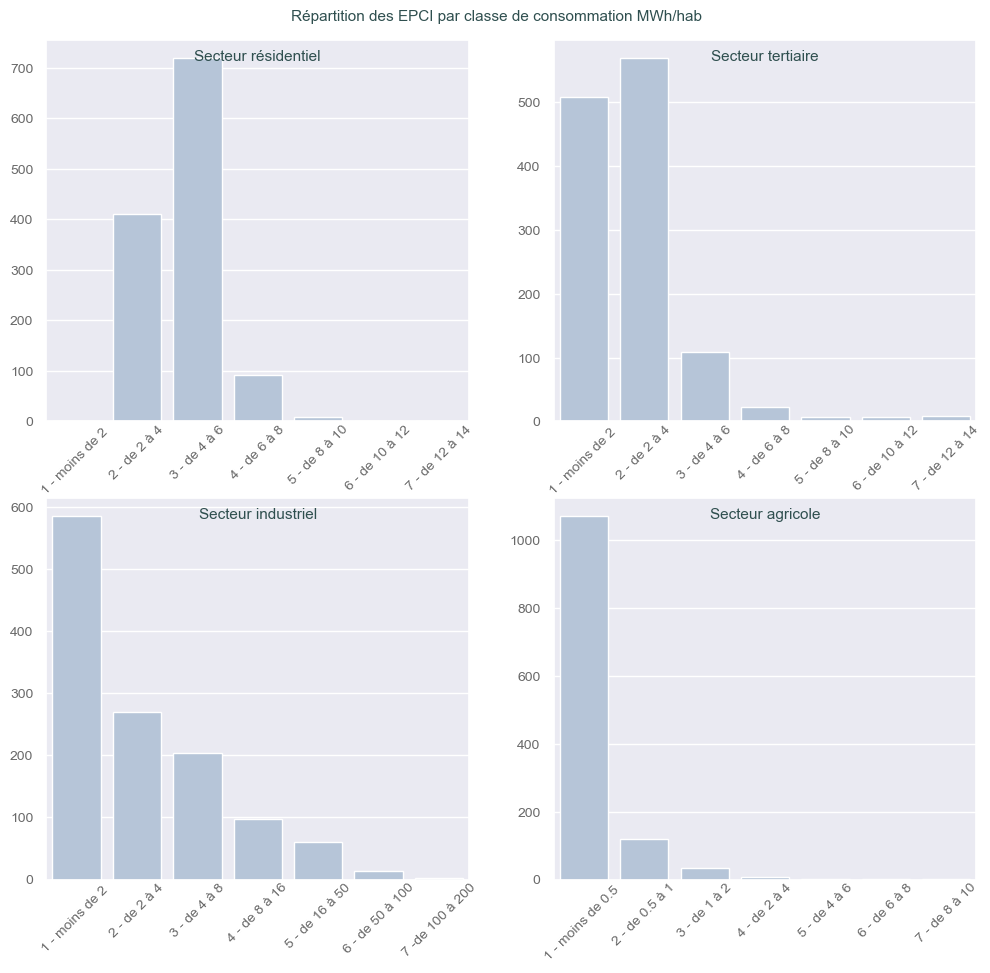

In [49]:
#Les 4 graphes sur une même figure
df=df_carte
variables=["classe_totale_hab","classe_resid_hab","classe_ter_hab","classe_indus_hab","classe_agri_hab"]
libelles=["Tous secteurs","Secteur résidentiel","Secteur tertiaire","Secteur industriel","Secteur agricole"]
nlig=2
ncol=2
fig,ax=plt.subplots(nlig,ncol,figsize=(12,10))
for i in range(len(variables)-1):
    var=variables[i+1]
    k=np.int(i/ncol)
    l=np.mod(i,ncol)
    graf=ax[k][l]
    sns.countplot(df,x=var, color="lightsteelblue",ax=graf)
    graf.set_title(libelles[i+1],color=couleur_texte,size=11,pad=-15)        
    graf.set_xlabel("")    
    graf.set_ylabel("")
    plt.draw()
    labelx=[item.get_text() for item in graf.get_xticklabels(which='both')]
    labely=[item.get_text() for item in graf.get_yticklabels(which='both')]
    graf.set_xticklabels(labelx,rotation=45,color=couleur_axes,size=10,y=0.03)
    graf.set_yticklabels(labely,color=couleur_axes,size=10)
    
plt.subplots_adjust(top=0.95)
plt.suptitle("Répartition des EPCI par classe de consommation MWh/hab",color=couleur_texte,size=11);

In [50]:
#Lister les cas extrêmes
df_classement=df_carte[["nom_epci","totale_hab","resid_hab","ter_hab","indus_hab","agri_hab"]]


In [51]:
df_classement.sort_values(by="totale_hab",ascending=False).reset_index(drop=True)[["nom_epci","totale_hab"]].head(5)

nom_epci  totale_hab
0      CC Cœur de Maurienne Arvan  205.847641
1            CC Brie Nangissienne  141.859631
2         CA Saint-Avold Synergie  118.576790
3  CC du Bassin de Pont-à-Mousson  108.637898
4             CA Caux Seine Agglo  107.714782

In [52]:
df_classement.sort_values(by="resid_hab",ascending=False).reset_index(drop=True) [["nom_epci","resid_hab"]].head(5)

nom_epci  resid_hab
0                    CC Cœur Côte Fleurie  13.364929
1  CC de la Vallée de Chamonix-Mont-Blanc   9.873538
2                       CC de l'Île de Ré   8.967074
3                        CC Gally Mauldre   8.838873
4                   CC Pyrénées catalanes   8.661549

In [53]:
df_classement.sort_values(by="ter_hab",ascending=False).reset_index(drop=True) [["nom_epci","ter_hab"]].head(5)

nom_epci    ter_hab
0             CC Porte du Jura  26.573566
1  CU Le Havre Seine Métropole  25.130702
2         CC du Val de l'Aisne  24.295201
3     CC Entre Bièvre et Rhône  18.593983
4               CC Val Vanoise  18.504959

In [54]:
df_classement.sort_values(by="indus_hab",ascending=False).reset_index(drop=True) [["nom_epci","indus_hab"]].head(5)

nom_epci   indus_hab
0      CC Cœur de Maurienne Arvan  194.257443
1            CC Brie Nangissienne  133.874055
2         CA Saint-Avold Synergie  105.039909
3             CA Caux Seine Agglo   99.782330
4  CC du Bassin de Pont-à-Mousson   98.298393

In [55]:
df_classement.sort_values(by="agri_hab",ascending=False).reset_index(drop=True) [["nom_epci","agri_hab"]].head(5)

nom_epci  agri_hab
0     CC Chinon, Vienne et Loire  8.544908
1              CC du Sammiellois  7.735458
2        CC Haut-Léon Communauté  4.021126
3            CC Cœur Haute Lande  2.563522
4  CC du Grand Saint-Émilionnais  2.501395

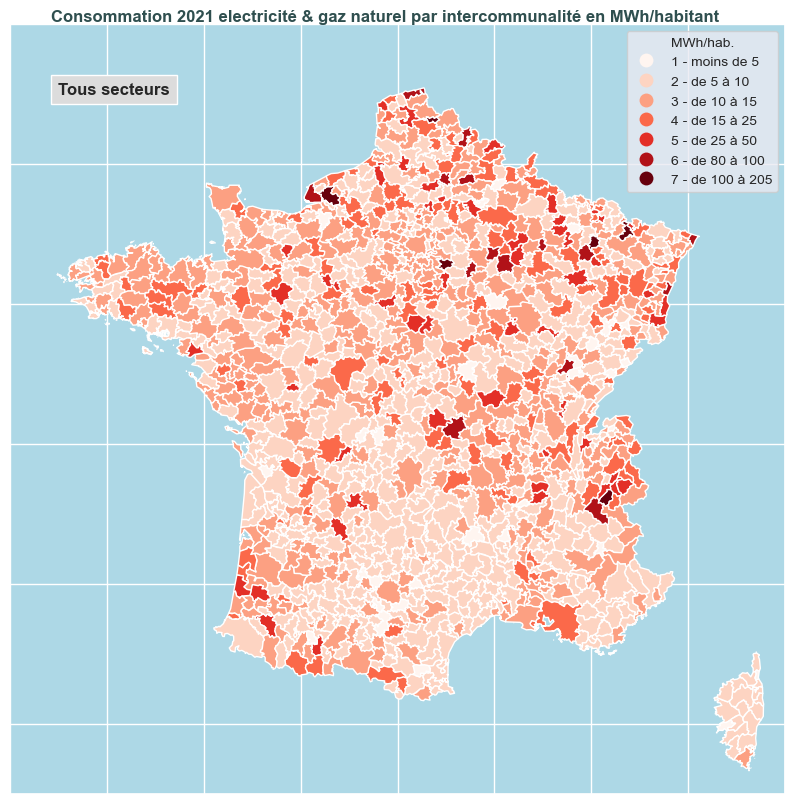

In [56]:
#carte 1 version geoplot
fig,ax =plt.subplots(figsize=(10,10))

df=df_carte_1

    
df.plot("classe_totale_hab",cmap="Reds",ax=ax,legend=True,
        legend_kwds={"loc": "upper right","fontsize":10,"title":"MWh/hab.","title_fontsize":10})
ax.set_facecolor("lightblue")
ax.set(xlim=(-6,10),ylim=(41,52))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(-5,51,"Tous secteurs",fontweight = 'bold',
             bbox={'facecolor': 'gainsboro', 'alpha': 1, 'pad': 5} ,size=12);   
plt.subplots_adjust(top=1.05)
plt.suptitle("Consommation 2021 electricité & gaz naturel par intercommunalité en MWh/habitant",color=couleur_texte,size=12,weight="bold");

#Image
fig.savefig("énergie_graphe_11") 

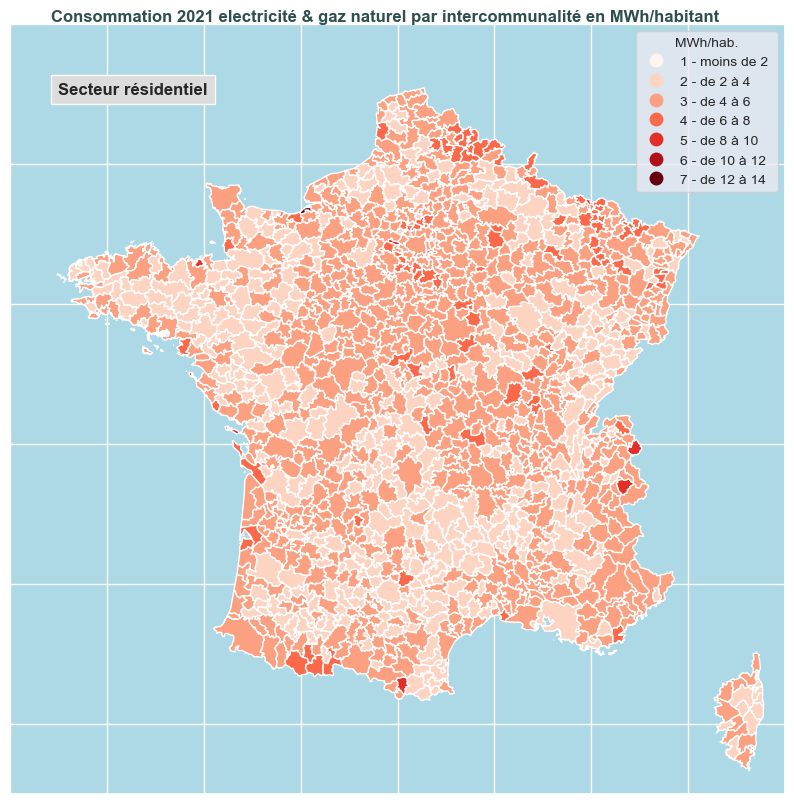

In [57]:
#carte 2 version geoplot
fig,ax =plt.subplots(figsize=(10,10))

df=df_carte_2

#contour_epci.plot(ax=ax,color="azure",edgecolor="lightblue",linewidth=1)
    
df.plot("classe_resid_hab",cmap="Reds",ax=ax,legend=True,
         legend_kwds={"loc": "upper right","fontsize":10,"title":"MWh/hab.","title_fontsize":10})
ax.set_facecolor("lightblue")
ax.set(xlim=(-6,10),ylim=(41,52))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(-5,51,"Secteur résidentiel",fontweight = 'bold',
             bbox={'facecolor': 'gainsboro', 'alpha': 1, 'pad': 5} ,size=12);  
plt.subplots_adjust(top=1.05)
plt.suptitle("Consommation 2021 electricité & gaz naturel par intercommunalité en MWh/habitant",color=couleur_texte,size=12,weight="bold");

#Image
fig.savefig("énergie_graphe_12") 

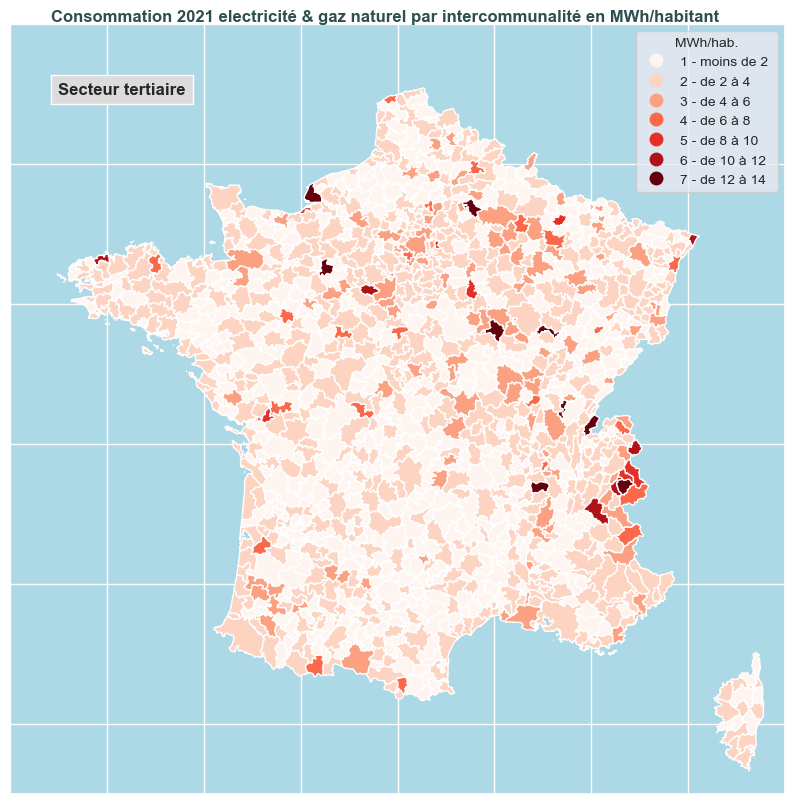

In [58]:
#carte 3 version geoplot

df=df_carte_3

fig,ax =plt.subplots(figsize=(10,10))    
df.plot("classe_ter_hab",cmap="Reds",ax=ax,legend=True,
         legend_kwds={"loc": "upper right","fontsize":10,"title":"MWh/hab.","title_fontsize":10})
ax.set_facecolor("lightblue")
ax.set(xlim=(-6,10),ylim=(41,52))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(-5,51,"Secteur tertiaire",fontweight = 'bold',
             bbox={'facecolor': 'gainsboro', 'alpha': 1, 'pad': 5} ,size=12);  
plt.subplots_adjust(top=1.05)
plt.suptitle("Consommation 2021 electricité & gaz naturel par intercommunalité en MWh/habitant",color=couleur_texte,size=12,weight="bold");

#Image
fig.savefig("énergie_graphe_13") 

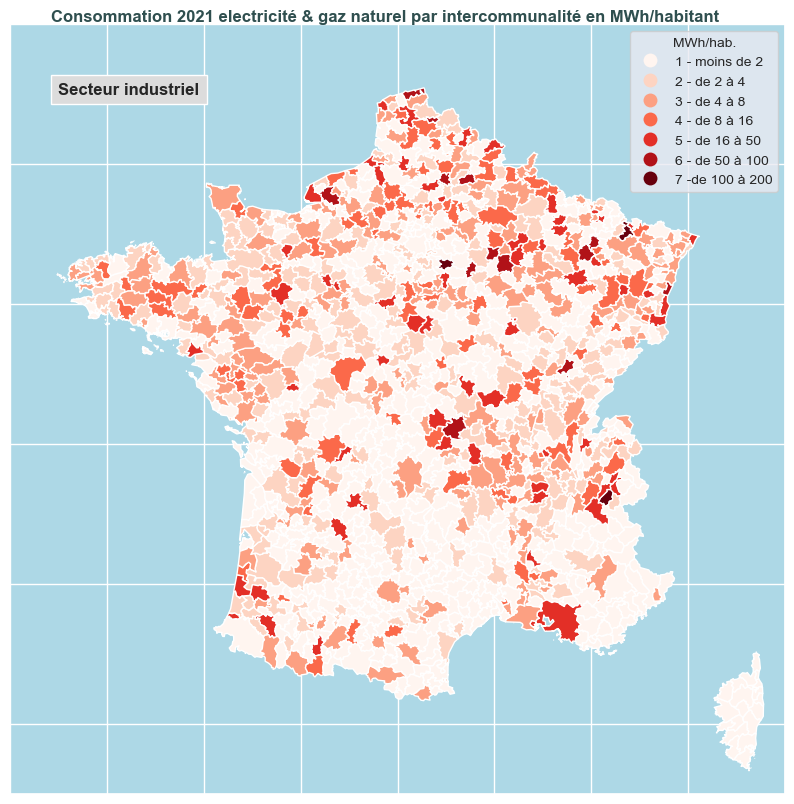

In [59]:
#carte 4 version geoplot

df=df_carte_4

fig,ax =plt.subplots(figsize=(10,10))    
df.plot("classe_indus_hab",cmap="Reds",ax=ax,legend=True,
         legend_kwds={"loc": "upper right","fontsize":10,"title":"MWh/hab.","title_fontsize":10})
ax.set_facecolor("lightblue")
ax.set(xlim=(-6,10),ylim=(41,52))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(-5,51,"Secteur industriel",fontweight = 'bold',
             bbox={'facecolor': 'gainsboro', 'alpha': 1, 'pad': 5} ,size=12);  
plt.subplots_adjust(top=1.05)
plt.suptitle("Consommation 2021 electricité & gaz naturel par intercommunalité en MWh/habitant",color=couleur_texte,size=12,weight="bold");

#Image
fig.savefig("énergie_graphe_14") 

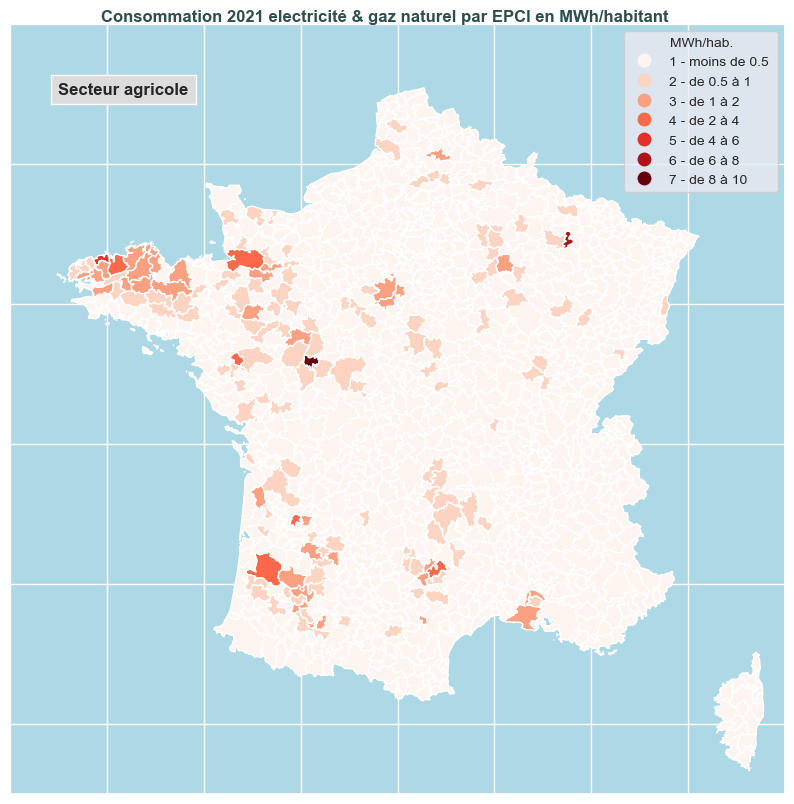

In [60]:
#carte 5 version geoplot

df=df_carte_5

fig,ax =plt.subplots(figsize=(10,10))    
df.plot("classe_agri_hab",cmap="Reds",ax=ax,legend=True,
         legend_kwds={"loc": "upper right","fontsize":10,"title":"MWh/hab.","title_fontsize":10})
ax.set_facecolor("lightblue")
ax.set(xlim=(-6,10),ylim=(41,52))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(-5,51,"Secteur agricole",fontweight = 'bold',
             bbox={'facecolor': 'gainsboro', 'alpha': 1, 'pad': 5} ,size=12);  

plt.subplots_adjust(top=1.05)
plt.suptitle("Consommation 2021 electricité & gaz naturel par EPCI en MWh/habitant",color=couleur_texte,size=12,weight="bold");

#Image
fig.savefig("énergie_graphe_15") 

In [61]:
#Préparation carte1  carte explore
couleurs=["lightgray","lightskyblue","plum","greenyellow","yellowgreen","gold","orangered"]  #pour explore
kargs={"location":[47.0,1.7],"zoom_start":6}

carte_1=df_carte_1.explore(
    column="classe_totale_hab",
    legend=True,
    legend_kwds={"caption":"Total en MWh / hab."},
    cmap=couleurs,
    style_kwds={"color":"gray","opacity":0.2,"fillOpacity":1},
    map_kwds={"scrollWheelZoom":False},  
    control_scale=True,
    **kargs   
)

#ajout d'un titre  --> couleur du titre à changer
titre_1 ="Consommation totale en MWh/habitant - Electricité/Gaz naturel 2021"
titre_html_1 = '''
             <h3 align="center" style="font-size:14px"><b>{}</b></h3>
             '''.format(titre_1)   
carte_1.get_root().html.add_child(folium.Element(titre_html_1))

carte_1

In [62]:
#FIN PROVISOIRE
df_carte.columns[5:9]

Index(['resid_hab', 'ter_hab', 'indus_hab', 'agri_hab'], dtype='object')